In [1]:
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors, MACCSkeys
from rdkit.ML.Descriptors import MoleculeDescriptors

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

from mordred import Calculator, descriptors
import sklearn.preprocessing as preprocessing

# Read the data

In [53]:
train_test_path = "../../data_for_modeling/filter_data/all_data/unclean_data/HDAC2_train_test_unclean_data_all.xlsx"; 
train_dataset = pd.read_excel(train_test_path, sheet_name='train_dataset')
test_dataset = pd.read_excel(train_test_path, sheet_name='test_dataset')

print(len(train_dataset), len(test_dataset))

1668 418


In [48]:
train_dataset.head()

,CID,SMILES,AVG_IC50_uM,FINAL_LABEL
0,162654809,CCC(=O)CCCCC[C@H](NC(=O)C1CN(C)C1)c1[nH]c(-c2c...,1.2500,Inactive
1,162649434,CCC(=O)CCCCC[C@H](NC(=O)[C@H]1CC12CCN(CC)CC2)c...,0.0200,Active
2,71574948,O=C(NO)c1ccc(C(=O)NCCc2ccncc2)cc1,0.3400,Active
3,118613747,C[C@@]12CSC(=N1)c1csc(n1)CNC(=O)C[C@@H](/C=C/C...,0.0205,Active
4,86268316,Nc1ccccc1NC(=O)c1ccc(C=C2CN(Cc3ccccc3)C2)cc1,1.0000,Inactive


In [49]:
test_dataset.head()

,CID,SMILES,AVG_IC50_uM,FINAL_LABEL
0,164627049,CCC(=O)CCCCC[C@H](NC(=O)[C@H]1CC12CCN(CC)CC2)c...,0.22,Active
1,137645400,CN1CCc2c(c3ccccc3n2Cc2ccc(/C=C/C(=O)NO)cc2)C1,1.65,Inactive
2,136244075,CC(=O)N1C(=NCc2ccc(C(=O)Nc3ccccc3N)cc2)NC(=O)C...,0.12,Active
3,127037614,O=C(/C=C/c1ccc(CNc2nccc(-c3cccnc3)n2)cc1)NO,0.19,Active
4,136239318,Nc1ccccc1NC(=O)c1ccc(CN=C2NC(=O)C(Cc3ccccc3)N2...,0.07,Active


# 2. Xây dựng mô hình với Modred descriptors

## 2.1. Constructing X and Y

__Mã hóa cấu trúc phân tử bằng Modred descriptors__

<b>Use this for new data</b>

In [ ]:
def process_modred(data):
    calc = Calculator(descriptors, ignore_3D=True)
    mols = [Chem.MolFromSmiles(smi) for smi in data]
    df = calc.pandas(mols, ipynb=False, quiet=True)
    return df

train_modred_descriptors = process_modred(train_dataset['SMILES'])
test_mordred_descriptors = process_modred(test_dataset['SMILES'])

- Do thuật toán mã hóa Modred không thể tìm được mọi features của SMILES nên sẽ có một số chỗ không phải là số thực mà là một chuỗi báo lỗi.
- Chuyển toàn bộ dữ liệu sang dạng số, nếu không chuyển được, ta cho bằng 0.

In [8]:
#Transfer to numeric
train_modred_descriptors = train_modred_descriptors.apply(pd.to_numeric, errors='coerce').fillna(0)
test_mordred_descriptors = test_mordred_descriptors.apply(pd.to_numeric, errors='coerce').fillna(0)
#Write to file
train_modred_descriptors.to_csv("../../output/modred_des/all_data/unclean_data/unclean_train_modred_descriptors.csv", index=False)
test_mordred_descriptors.to_csv("../../output/modred_des/all_data/unclean_data/unclean_test_modred_descriptors.csv", index=False)

__Use this if you already write to file__

In [50]:
#Read from file
train_modred_descriptors = pd.read_csv("../../output/modred_des/all_data/unclean_data/unclean_train_modred_descriptors.csv", low_memory=False)
test_modred_descriptors = pd.read_csv("../../output/modred_des/all_data/unclean_data/unclean_test_modred_descriptors.csv", low_memory=False)

__Check the data__

In [51]:
train_modred_descriptors.head()

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,24.317429,19.658010,0,1,40.195991,2.444322,4.802574,40.195991,1.256125,4.378506,...,10.270177,81.751083,439.238353,7.084490,3215,44,160.0,184.0,11.111111,7.277778
1,30.816147,24.817544,0,1,50.843271,2.589814,4.989615,50.843271,1.271082,4.625071,...,10.676993,98.286815,562.313076,6.942137,5913,61,210.0,248.0,14.236111,8.902778
2,15.694249,12.522906,0,0,27.223625,2.303479,4.606959,27.223625,1.296363,3.941747,...,9.600015,54.003014,285.111341,7.919759,1132,28,100.0,112.0,6.805556,4.888889
3,24.386229,18.626175,0,1,40.089182,2.464298,4.798679,40.089182,1.252787,4.376898,...,10.202814,83.418856,497.122517,8.425805,2788,49,162.0,187.0,11.201389,7.222222
4,22.058210,15.450876,0,1,36.463473,2.373134,4.746269,36.463473,1.302267,4.270645,...,10.204444,63.399101,369.184112,7.238904,2597,38,146.0,168.0,7.388889,6.138889


In [52]:
test_modred_descriptors.head()

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,32.591271,23.542765,0,1,55.010182,2.591214,4.906693,55.010182,1.309766,4.678689,...,10.656859,100.455146,573.367890,6.442336,6287,66,220.0,260.0,12.534722,9.430556
1,21.229782,15.750151,0,1,35.864520,2.541701,4.866870,35.864520,1.328316,4.237187,...,10.244627,76.902415,361.179027,7.223581,2005,43,144.0,171.0,7.750000,5.972222
2,29.214806,21.690672,0,3,48.443564,2.480911,4.809980,48.443564,1.309286,4.548474,...,10.517673,89.973355,494.206639,7.844550,5092,59,198.0,235.0,11.194444,8.055556
3,19.867940,14.372956,0,0,34.630188,2.326849,4.653699,34.630188,1.331930,4.168714,...,9.866668,60.263417,347.138225,8.072982,2077,35,128.0,144.0,7.166667,5.944444
4,24.248480,17.397678,0,3,40.756166,2.365043,4.686202,40.756166,1.314715,4.360431,...,10.163503,80.425535,413.185175,7.651577,3378,44,160.0,184.0,8.750000,6.833333


In [12]:
print(train_modred_descriptors.shape)
print(test_modred_descriptors.shape)

(1668, 1613)
(418, 1613)


In [13]:
all_mordred_descriptors = pd.concat([train_modred_descriptors, test_mordred_descriptors], ignore_index=False)

In [14]:
print(len(train_modred_descriptors), len(test_mordred_descriptors), len(all_mordred_descriptors))

1668 418 2086


In [15]:
train_modred_descriptors.head()

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,24.317429,19.658010,0,1,40.195991,2.444322,4.802574,40.195991,1.256125,4.378506,...,10.270177,81.751083,439.238353,7.084490,3215,44,160.0,184.0,11.111111,7.277778
1,30.816147,24.817544,0,1,50.843271,2.589814,4.989615,50.843271,1.271082,4.625071,...,10.676993,98.286815,562.313076,6.942137,5913,61,210.0,248.0,14.236111,8.902778
2,15.694249,12.522906,0,0,27.223625,2.303479,4.606959,27.223625,1.296363,3.941747,...,9.600015,54.003014,285.111341,7.919759,1132,28,100.0,112.0,6.805556,4.888889
3,24.386229,18.626175,0,1,40.089182,2.464298,4.798679,40.089182,1.252787,4.376898,...,10.202814,83.418856,497.122517,8.425805,2788,49,162.0,187.0,11.201389,7.222222
4,22.058210,15.450876,0,1,36.463473,2.373134,4.746269,36.463473,1.302267,4.270645,...,10.204444,63.399101,369.184112,7.238904,2597,38,146.0,168.0,7.388889,6.138889


## 2.2. Feature Selection

In [21]:
ic50_train = np.array(train_dataset['AVG_IC50_uM'])
ic50_train = np.nan_to_num(ic50_train.astype(float), nan=0)
print(len(ic50_train))
print(ic50_train[:5])

1668
[1.25   0.02   0.34   0.0205 1.    ]


### Filter by correlation features with IC50

In [22]:
#Concat IC50 into the feature matrix
train_modred_descriptors['IC50'] = ic50_train
corr_matrix = train_modred_descriptors.corr(method="pearson")

In [25]:
train_modred_descriptors.head()

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2,IC50
0,24.317429,19.658010,0,1,40.195991,2.444322,4.802574,40.195991,1.256125,4.378506,...,81.751083,439.238353,7.084490,3215,44,160.0,184.0,11.111111,7.277778,1.2500
1,30.816147,24.817544,0,1,50.843271,2.589814,4.989615,50.843271,1.271082,4.625071,...,98.286815,562.313076,6.942137,5913,61,210.0,248.0,14.236111,8.902778,0.0200
2,15.694249,12.522906,0,0,27.223625,2.303479,4.606959,27.223625,1.296363,3.941747,...,54.003014,285.111341,7.919759,1132,28,100.0,112.0,6.805556,4.888889,0.3400
3,24.386229,18.626175,0,1,40.089182,2.464298,4.798679,40.089182,1.252787,4.376898,...,83.418856,497.122517,8.425805,2788,49,162.0,187.0,11.201389,7.222222,0.0205
4,22.058210,15.450876,0,1,36.463473,2.373134,4.746269,36.463473,1.302267,4.270645,...,63.399101,369.184112,7.238904,2597,38,146.0,168.0,7.388889,6.138889,1.0000


In [26]:
corr_matrix.head()

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2,IC50
ABC,1.000000,0.973686,-0.010421,0.147968,0.888491,0.112741,0.085351,0.888491,-0.035622,0.416373,...,0.870541,0.975210,-0.151823,0.073648,0.964849,0.995448,0.983156,0.854080,0.984784,-0.150662
ABCGG,0.973686,1.000000,0.014091,0.113979,0.854950,0.110162,0.078598,0.854950,-0.066245,0.397607,...,0.878543,0.960220,-0.161078,0.098567,0.947580,0.970824,0.960168,0.891007,0.965588,-0.121644
nAcid,-0.010421,0.014091,1.000000,0.004873,-0.184446,-0.368479,-0.373960,-0.184446,-0.386793,-0.348585,...,-0.004261,0.011084,0.000048,0.472181,-0.038596,-0.022929,-0.034530,0.062709,0.006938,0.074928
nBase,0.147968,0.113979,0.004873,1.000000,0.050828,-0.107570,-0.125541,0.050828,-0.120126,-0.121646,...,0.183154,0.146204,0.030055,0.130648,0.127727,0.157963,0.166884,-0.003645,0.122251,-0.024283
SpAbs_A,0.888491,0.854950,-0.184446,0.050828,1.000000,0.524253,0.505716,1.000000,0.413156,0.776126,...,0.766778,0.853942,-0.140727,-0.324816,0.867549,0.886727,0.879097,0.789022,0.872864,-0.137153


1614


<Axes: >

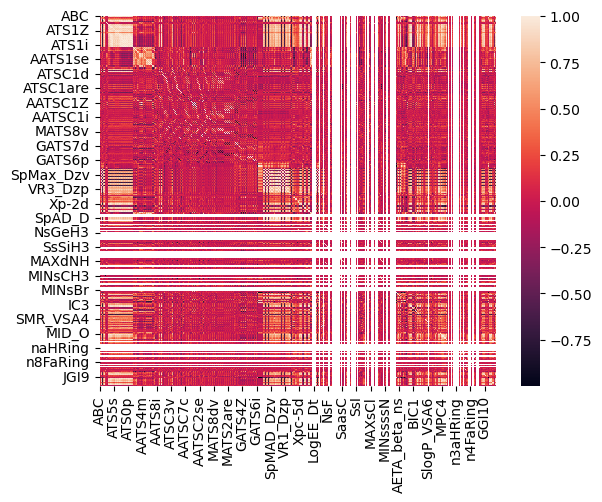

In [29]:
print(len(corr_matrix))
sns.heatmap(corr_matrix)

1372


<Axes: >

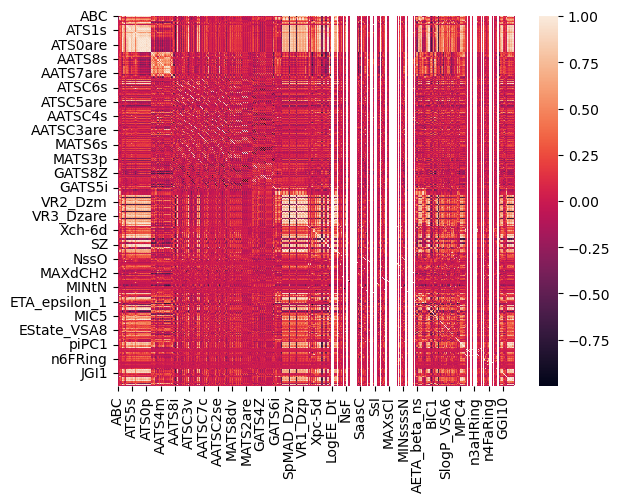

In [30]:
corr_matrix = corr_matrix.dropna(subset=['IC50'])
print(len(corr_matrix))
sns.heatmap(corr_matrix)

In [31]:
ic50_corrs_abs = corr_matrix['IC50'].abs()
features = corr_matrix.loc[ic50_corrs_abs > 0.05, :].index.tolist()
sorted_corr_matrix = corr_matrix.loc[features, features]

sorted_corr_matrix = sorted_corr_matrix.sort_values(by='IC50', ascending=False)
index_order = sorted_corr_matrix.index.tolist()
sorted_corr_matrix = sorted_corr_matrix[index_order].reindex(index_order)

881


<Axes: >

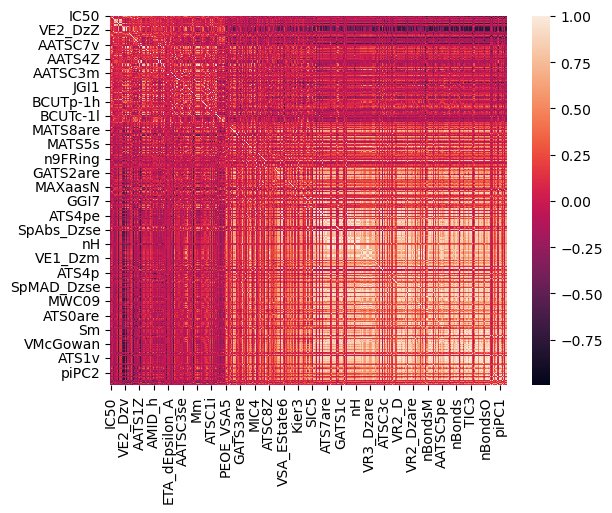

In [32]:
print(len(sorted_corr_matrix))
sns.heatmap(sorted_corr_matrix)

In [33]:
def set_zero_diagonal(sorted_corr_matrix):
    col_idx = 0
    arr = []
    for index, row in sorted_corr_matrix.iterrows():
        row.iloc[col_idx] = 0
        col_idx+=1
    return sorted_corr_matrix

upper_triangle = sorted_corr_matrix.where(np.triu(np.ones(sorted_corr_matrix.shape)).astype(bool))
upper_triangle = upper_triangle.fillna(0)
upper_triangle = set_zero_diagonal(upper_triangle)

881


<Axes: >

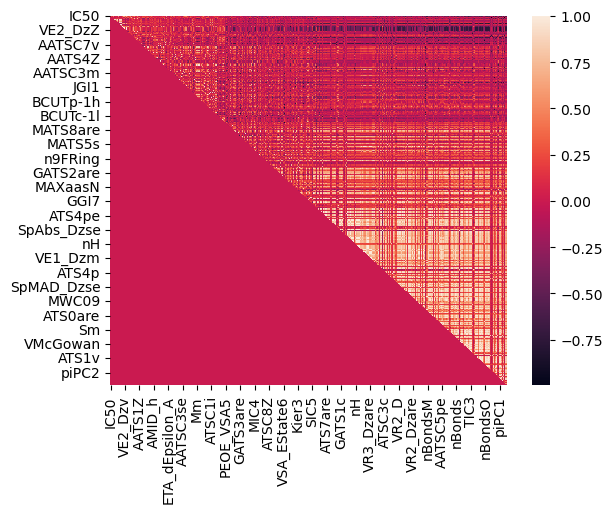

In [34]:
print(len(upper_triangle))
sns.heatmap(upper_triangle)

In [35]:
upper_triangle.head()

,IC50,BalabanJ,AATS4s,RPCG,NddssS,ETA_shape_x,AXp-6dv,JGI3,AATSC4se,ATSC4se,...,MAXssNH,piPC10,piPC9,MAXaasC,SddssS,AATS8d,IC5,AATSC6se,IC4,IC3
IC50,0.0,0.216988,0.201180,0.197108,0.191658,0.190978,0.190416,0.185754,0.184430,0.184001,...,-0.195652,-0.196049,-0.197332,-0.206402,-0.208037,-0.211873,-0.217365,-0.217614,-0.222886,-0.230317
BalabanJ,0.0,0.000000,0.223928,0.353344,0.046208,0.121180,0.446188,0.207478,-0.088607,-0.010218,...,-0.296206,-0.640121,-0.631924,-0.384551,-0.045321,-0.567243,-0.577094,-0.154022,-0.576059,-0.548434
AATS4s,0.0,0.000000,0.000000,0.113789,0.370700,0.286317,-0.264714,0.338329,0.054271,0.050892,...,-0.216575,0.037427,0.034795,-0.532929,-0.382181,0.223933,-0.062671,-0.317001,-0.067254,-0.051078
RPCG,0.0,0.000000,0.000000,0.000000,0.001645,0.075334,0.215660,-0.020177,-0.050514,0.170671,...,-0.410638,-0.514401,-0.506658,0.048267,-0.002277,-0.443591,-0.735427,-0.112379,-0.716858,-0.730912
NddssS,0.0,0.000000,0.000000,0.000000,0.000000,0.633517,0.092395,0.203378,-0.009012,-0.040324,...,-0.130751,0.067585,0.063519,-0.233103,-0.997141,0.093001,0.020090,-0.223045,0.016592,-0.000965


In [37]:
upper_triangle.to_excel("../../output/corr_matrix/unclean_data/HDAC2_upper_triangle_all_data.xlsx")

### Remove correlated features

In [39]:
def remove_correlated_features(sorted_df, pcc_point):
    above_pcc_point = (sorted_df > pcc_point) | (sorted_df < -pcc_point)
    shapes = [] 
    features = []
    dropped_features = set()
    for idx, row in sorted_df.iterrows():
        if idx in dropped_features:
            continue
        print("[+] Working with row: " + idx)
        cols_rows_to_drop = []
        for col in sorted_df.columns:
            if above_pcc_point.loc[idx, col]:
                cols_rows_to_drop.append(col)
        # drop the columns
        print("[-] Detected in this row:")
        print(cols_rows_to_drop)
        for col_row_index in cols_rows_to_drop:
            dropped_features.add(col_row_index)
        #Drop the data
        sorted_df = sorted_df.drop(cols_rows_to_drop, axis=1).drop(cols_rows_to_drop, axis=0)
        shapes.append(sorted_df.shape)
        features.append(sorted_df.index.to_list())  
        # check if there are any rows left
        if len(sorted_df) == 0:
            break
    return sorted_df, shapes, features

In [40]:
def write_features_to_file(pcc_point, upper_triangle, pcc_matrix_path, shapes_and_features_path):
    matrix_before_processing = upper_triangle.iloc[1:, 1:]
    result_matrix, shapes, features = remove_correlated_features(matrix_before_processing, pcc_point=pcc_point)
    
    result_features = result_matrix.columns.to_list()
    lengths = []
    features_to_file = []
    tmp_features = []
    for features in result_features:
        tmp_features.append(features)
        lengths.append(len(tmp_features))
        features_to_file.append(tmp_features.copy())

    #Write to file processed pcc matrix
    result_matrix['IC50'] = upper_triangle.iloc[0]
    result_matrix.to_excel(pcc_matrix_path, index=True)

    # create a DataFrame with the shapes and features
    df_shapes = pd.DataFrame({'Len': lengths, 'Features': features_to_file})
    # write the DataFrame to an Excel file
    df_shapes.to_excel(shapes_and_features_path, index=False)

In [46]:
for pcc_point in [0.75, 0.95]:
    write_features_to_file(pcc_point=pcc_point, upper_triangle=upper_triangle,
                        pcc_matrix_path="../../output/pcc_processed_matrix/unclean_data/" + str(pcc_point)+ "_pcc_matrix_all_data.xlsx",
                        shapes_and_features_path="../../output/shapes_and_features/unclean_data/" + str(pcc_point)+ "_shapes_and_features_all_data.xlsx")

[+] Working with row: BalabanJ
[-] Detected in this row:
[]
[+] Working with row: AATS4s
[-] Detected in this row:
['AATS5s', 'AATS5se', 'AATS4se', 'AATSC0s', 'AATS0s', 'AATS5are', 'AATS5pe', 'AATS4are', 'AATS4pe', 'AATS0se', 'Mse', 'ETA_dEpsilon_A', 'AATS2s', 'AATS7s', 'AATS6s', 'AATS0pe', 'AATS0are', 'AATS4dv', 'Mare', 'Mpe', 'AATS3s']
[+] Working with row: RPCG
[-] Detected in this row:
['MWC03', 'SRW04', 'MWC02', 'piPC1', 'SRW02', 'VAdjMat']
[+] Working with row: NddssS
[-] Detected in this row:
['AATSC1Z', 'MAXddssS', 'MINddssS', 'SddssS']
[+] Working with row: ETA_shape_x
[-] Detected in this row:
['Xc-4d']
[+] Working with row: AXp-6dv
[-] Detected in this row:
['AXp-5dv', 'AXp-4dv', 'AXp-2dv', 'AXp-7dv', 'AXp-1dv', 'AXp-3dv']
[+] Working with row: JGI3
[-] Detected in this row:
[]
[+] Working with row: AATSC4se
[-] Detected in this row:
['ATSC4se', 'AATSC4are', 'ATSC4are', 'AATSC4pe', 'ATSC4pe', 'MATS4s', 'MATS4se', 'AATSC4s', 'MATS4are', 'MATS4pe']
[+] Working with row: VE2_A


[+] Working with row: MATS3Z
[-] Detected in this row:
['MATS3m', 'AATSC3Z', 'AATSC3m', 'ATSC3Z', 'ATSC3m']
[+] Working with row: ATSC4dv
[-] Detected in this row:
['AATSC4dv', 'MATS4dv']
[+] Working with row: AMID_h
[-] Detected in this row:
['ETA_epsilon_4', 'ETA_dEpsilon_C']
[+] Working with row: GATS6m
[-] Detected in this row:
['GATS6Z', 'AATSC6Z', 'MATS6m', 'MATS6Z']
[+] Working with row: AATSC2Z
[-] Detected in this row:
['AATSC2m', 'MATS2Z', 'MATS2m', 'ATSC2Z']
[+] Working with row: GATS1d
[-] Detected in this row:
[]
[+] Working with row: JGT10
[-] Detected in this row:
['AETA_eta_BR', 'JGI1', 'AATSC0d']
[+] Working with row: GATS3d
[-] Detected in this row:
['MATS3d', 'AATSC3d']
[+] Working with row: AATSC2dv
[-] Detected in this row:
['MATS2dv', 'GATS2dv']
[+] Working with row: GATS4d
[-] Detected in this row:
['ATSC4d', 'AATSC4d', 'MATS4d']
[+] Working with row: MATS7i
[-] Detected in this row:
['AATSC7i', 'GATS7i']
[+] Working with row: nS
[-] Detected in this row:
[]
[+] 